In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint
from scipy.integrate import quad
import seaborn as sns
from matplotlib import rcParams
from scipy.interpolate import InterpolatedUnivariateSpline
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})
Merge_imripy = np.zeros((10, 10))



π = np.pi
G = 4.4959e-15            #in units of M☉^-1 pc^3 yr^-2
c = 0.3068                #in units of pc yr^-1
ρ_eq = 3.1812e3           #in units of M☉ pc^-3 with ρ_eq=2.15368e-16 kg m^-3
t = 13.78e9               #in units of yrs corresponding to t_0=13.78Gyr
yr = 3.154e7              # in units of seconds
pc = 3.0857e16            # in meters
yr = 3.154e7              # in units of seconds
t_eq = 1.59246e12/yr      # in units of seconds

σ_eq = 0.005
ρ_m  = 4e19                #ρ_m=4e19 M☉ Gpc^-3




m1 = np.geomspace(1, 1e5, 10)
m2 = np.geomspace(1e-4, 10, 10)

m_1_list = m1.tolist()
m_2_list = m2.tolist()


Δ_1_list = np.zeros(len(m_1_list))
Δ_2_list = np.zeros(len(m_2_list))



dm = (m_1_list[0] -  m_2_list[0])/2 

for i, (m_1, m_2) in enumerate(zip(m_1_list, m_2_list)):
    Δ_1_list[i] = Δ_2_list[i] = (m_1 + dm)  - (m_2 - dm)
    

In [2]:
file = np.load('tmofj0.npz')
ji_ref_list = file['arr_0']
tm_ref_list = file['arr_1']

f_tm_of_ji =  InterpolatedUnivariateSpline(ji_ref_list, tm_ref_list, ext = 2)

f_tm_of_ji_prime = f_tm_of_ji.derivative()

λ_0 = 4

def s(λ_0): # S_dec of the binary decouple.
    return ((0.03095*λ_0 + 0.3425)*λ_0)
    
def t(λ_0): 
    return ((np.sqrt(3/(8*π*G*ρ_eq)))*(((2/3)*(s(λ_0)-2)*np.sqrt(s(λ_0)+1))+(4/3)))
    

def merger_rate(m_1,m_2,Δ_1,Δ_2,j_i):
    
    def ρ_bar(m):
        return ((ρ_eq/2)*(t_eq**(3/2))*((2*G*m)**(3/4))) 
    
    def M_halo(m,λ_0):
        return (((16*π)/3)*ρ_bar(m)*((2*G*m*(t(λ_0)**2))**(1/4)))
    
    def M(m,λ_0):
        return (m + M_halo(m,λ_0))
    
    def M_binary_initial(m_1,m_2, λ_0):
        return (m_1 + m_2 + M_halo(m_1,λ_0) + M_halo(m_2,λ_0))
      
    def f_(m):
        return f*P(m)
    
    def f_b(m_1,m_2):
        return  f_(m_1)+f_(m_2)
    
    def D(λ_0):
        return ( 1 + 0.4440 * λ_0)/ np.sqrt(1 + 0.0583 * λ_0)
    
    def j_X(m_1, m_2, Δ_1, Δ_2, X):
        return 0.4045 * np.sqrt(f**2 + 1.2005 * (σ_eq**2))  * np.sqrt((m_1 + m_2)/M_binary_initial(m_1,m_2, λ_0)) * D(λ_0) * (X/(f_b(m_1,m_2) * np.sqrt(Δ_1*Δ_2)))
    
    def γ_X(X, m_1,m_2,Δ_1,Δ_2,j_i):    
        return j_i / j_X(m_1, m_2, Δ_1, Δ_2, X)

    def PDF(m):
        return (P(m)/m)

    I = quad(PDF, 5, np.inf)     # Taking limits of the PBH mass from 5 M☉ to 100 M☉ instead of 
                                 # 0 to infinity.
    
    n_T = f*ρ_eq*I[0]            #n_T=f*ρ_eq∫(P(m)/m)*dm 
   
    def x̄(m_1,m_2,Δ_1,Δ_2):
        return (((3*(m_1+m_2))/(8*π*ρ_eq*f_b(m_1,m_2)*np.sqrt(Δ_1*Δ_2)))**(1/3))
    
    X=np.geomspace(1e-2, 1e10*pc, 1000000) 
    
    def integrand(X,m_1,m_2,Δ_1,Δ_2,j_i):
        return (1/f_tm_of_ji_prime(j_i)) * (1/j_i) * ((γ_X(X,m_1,m_2,Δ_1,Δ_2,j_i)**2)/ ((1 + (γ_X(X,m_1,m_2,Δ_1,Δ_2,j_i)**2))**(3/2))) * np.exp(- X * ((4*π)/3) * (x̄(m_1,m_2,Δ_1,Δ_2)**3) * n_T)
    
    f2=np.vectorize(integrand) 
    
    Merge_imripy = np.zeros((10, 10))
    
    return  (ρ_m/2) * (((f**2)* (m_1 + m_2))/(f_b(m_1,m_2)*np.sqrt(Δ_1*Δ_2))) * np.minimum((P(m_1)*Δ_1)/m_1, (P(m_2)*Δ_2)/m_2) * ((P(m_1)*Δ_1)/m_1 + (P(m_2)*Δ_2)/m_2) *   (np.trapz(f2(X,m_1,m_2,Δ_1,Δ_2, j_i),X))



In [3]:
# Calculation of the 2D merger rate for Powerlaw PBH mass distribution. 
#The resolution of the PBHs masses m_1 is Δ_1 and of m_2 is Δ_2 with Δ_1=Δ_2=Δ.

e0_array = 1- np.geomspace(1e-4, 0.09, 10)
e0_list = e0_array.tolist()

def j0(e0):
    return np.sqrt(1 - (e0**2))



j_i_list = np.zeros(len(e0_list))
for i, e0 in enumerate(e0_list):
    j_i_list[i] = j0(e0)



Merge_imripy = np.zeros((10, 10))



for i in range(10):
    for j in range(10):
        
        f_pbh = 4.3e-3
        f = 0.85*f_pbh
        
          
        def P(m): #Powerlaw PBH mass distribution
            α = 1.6
            M = 5     #in units of M☉
            return ((α-1)/M) * ((m/M)**(-α))

        if i==j:
            Merge_imripy[i,j] = 0.5 * merger_rate(m_1_list[i], m_2_list[j], Δ_1_list[i], Δ_2_list[j], j_i_list[i])
            
        else:
            Merge_imripy[i,j] = merger_rate(m_1_list[i], m_2_list[j], Δ_1_list[i], Δ_2_list[j], j_i_list[i])   
    
        
np.savez("imripymerger", Merge_imripy)



In [ ]:
# Calculation of the 2D merger rate for Log-Normal PBH mass Distribution. 
#The resolution of the PBHs masses m_1 is Δ_1 and of m_2 is Δ_2.


Merger = np.zeros((11, 11))


for i in range(11):
    for j in range(11):
        
        f_pbh = 3.7e-3
        f = 0.85*f_pbh 
        
        def P(m):               #Log-Normal PBH mass Distribution
            σ = 0.6
            m_c = 15               #in units of M☉
            return  (1/(σ * m * math.sqrt(2*π))) * math.exp(-((math.log(m/m_c))**2)/(2*(σ**2)))

        if i==j:
            Merger[i, j] = 0.5 * merger_rate(m_1_list[i], m_2_list[j], Δ_1_list[i], Δ_2_list[j], j_i_list[i])
            
        else:
            Merger[i, j] = merger_rate(m_1_list[i], m_2_list[j], Δ_1_list[i], Δ_2_list[j], j_i_list[i])
            

np.savez("imripymerger", Merger_imripy)

In [7]:
file = np.load('imripymerger.npz')
file.files

Merge_imripy = file['arr_0']

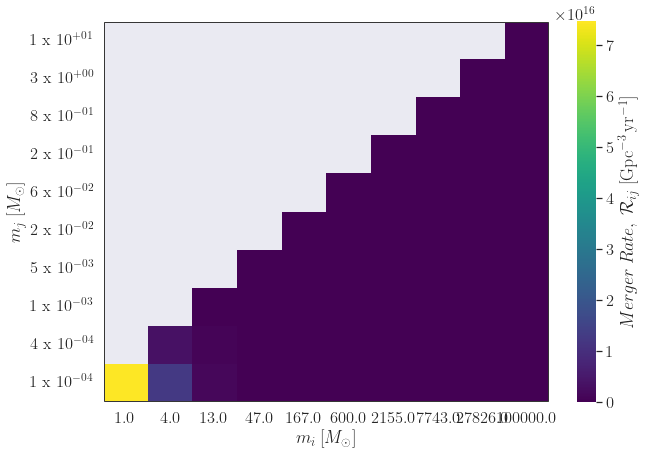

In [40]:
np.load('imripymerger.npz')



mask = np.tril(Merge_imripy, k=-1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax = plt.subplots(figsize=(10, 7))  

sns.set(font_scale=1.5)

ax = sns.heatmap(Merge_imripy, mask = mask,  cmap = 'viridis', cbar = True, 
                 cbar_kws = {"shrink": 1,'label': '$Merger \: Rate, \: \mathcal{R}_{ij} \: [\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}]$'},
                  )

    

# make frame visible
for _, spine in ax.spines.items():
    spine.set_visible(True)
    
    
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'



y = [np.ceil(m_2)  for m_2 in m_2_list]
x = [np.ceil(m_1)  for m_1 in m_1_list]

yticklabels = []
xticklabels = []
for k, m_1 in enumerate(m_1_list):
    printstr = '{:.0e}'.format(m_1)
    ls = printstr.split('e')
    xticklabels.append((ls[0]+' x $10^{'  +ls[1] + '}$'))

    
for k, m_2 in enumerate(m_2_list):
    printstr = '{:.0e}'.format(m_2)
    ls = printstr.split('e')
    yticklabels.append((ls[0]+' x $10^{'  +ls[1] + '}$'))



ax.set_yticklabels(yticklabels,rotation = 360)
ax.set_xticklabels(x)


ax.axhline(y=0, color='k',linewidth=3, zorder=2.5)
ax.axhline(y=Merge_imripy.shape[1], color='k',linewidth=3)
ax.axvline(x=0, color='k',linewidth=3)
ax.axvline(x=Merge_imripy.shape[0], color='k',linewidth=3)


ax.invert_yaxis()
plt.xlabel('$m_{i}\:[M_{\odot}]$', fontsize = 18)
plt.ylabel('$m_{j}\: [M_{\odot}]$', fontsize = 18)
plt.savefig('IMRIPYPWRLAW.pdf', bbox_inches = 'tight')
plt.show()     